<a href="https://colab.research.google.com/github/rpimaster/OAI/blob/main/03-detector/simple-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# architecture of encoder
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(8, 8, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=3),
    nn.Sigmoid(),
    nn.Flatten()
)

In [4]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_features, num_classes, num_hidden=512):
        super().__init__()
        self.encoder = encoder
        self.perceptron = nn.Sequential(
            nn.Linear(num_features,num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden,num_classes),
        )
    def forward(self, x):
        features = self.encoder(x)
        logits = self.perceptron(features)
        if self.training:
            return logits
        else:
            return F.softmax(logits, dim=1)

In [5]:
classifier = Classifier(encoder,72,10).to(device)

In [6]:
!wget http://agentspace.org/download/mnist_classifier.pth
model_name = 'mnist_classifier.pth'
classifier.load_state_dict(torch.load(model_name, map_location=device))

--2025-11-26 15:03:47--  http://agentspace.org/download/mnist_classifier.pth
Resolving agentspace.org (agentspace.org)... 62.168.101.9
Connecting to agentspace.org (agentspace.org)|62.168.101.9|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.agentspace.org/download/mnist_classifier.pth [following]
--2025-11-26 15:03:49--  https://www.agentspace.org/download/mnist_classifier.pth
Resolving www.agentspace.org (www.agentspace.org)... 62.168.101.9
Connecting to www.agentspace.org (www.agentspace.org)|62.168.101.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197945 (193K)
Saving to: ‘mnist_classifier.pth’

mnist_classifier.pt 100%[===================>] 193.31K   380KB/s    in 0.5s    

2025-11-26 15:03:51 (380 KB/s) - ‘mnist_classifier.pth’ saved [197945/197945]



<All keys matched successfully>

In [7]:
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 449kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.98MB/s]


torch.Size([1, 28, 28])


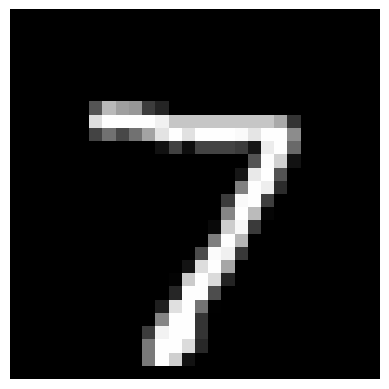

In [8]:
sample = test_dataset[0][0]
print(sample.shape)
plt.imshow(sample.squeeze(0), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
with torch.no_grad():
    logits = classifier(sample.unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()

print(logits.shape)
print(logits)
category = np.argmax(logits)
print(category)

(10,)
[ -8.428147   -5.808369   -1.3307896   0.5481103  -1.7439861  -5.1469684
 -22.796312   15.168757   -3.4929848   2.3366494]
7


In [10]:
def softmax(x):
    # subtract max for numerical stability
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

print(np.round(softmax(logits),3))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [11]:
scale = 4
print(scale)
print(np.round(softmax(logits/scale),3))

4
[0.002 0.005 0.014 0.023 0.013 0.006 0.    0.892 0.008 0.036]


In [12]:
class ScaledSoftmax(nn.Module):
    def __init__(self, dim=1, scale=1.0):
        super().__init__()
        self.scale = scale
        self.softmax = nn.Softmax(dim=dim)

    def forward(self, x):
        return self.softmax(x / self.scale)

In [13]:
classifier

Classifier(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (13): Sigmoid()
    (14): Flatten(start_dim=1, end_dim=-1)
  )
  (perceptron): Sequential(
    (0): Linear(in_features=72, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [14]:
# convert the perceptron into convolutional layers
fc1 = classifier.perceptron[0]  # Linear(72 → 512)
fc2 = classifier.perceptron[2]  # Linear(512 → 10)
conv_fc1 = nn.Conv2d(8, fc1.out_features, kernel_size=3, bias=True).to(device)
conv_fc2 = nn.Conv2d(fc1.out_features, fc2.out_features, kernel_size=1, bias=True).to(device)
# copy weights
with torch.no_grad():
    conv_fc1.weight.copy_(fc1.weight.view(fc1.out_features, 8, 3, 3))
    conv_fc1.bias.copy_(fc1.bias)
    conv_fc2.weight.copy_(fc2.weight.view(fc2.out_features, fc2.in_features, 1, 1))
    conv_fc2.bias.copy_(fc2.bias)
# create fully-convolutional perceptron
fully_convolutional_perceptron = nn.Sequential(
    conv_fc1,
    nn.ReLU(),
    conv_fc2
)
# remove flattening from the encoder
encoder_without_flattening = nn.Sequential(*list(classifier.encoder.children())[:-1])
# compose the new model
model = nn.Sequential(
    encoder_without_flattening,
    fully_convolutional_perceptron,
    ScaledSoftmax(dim=1,scale=4)
)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (13): Sigmoid()
  )
  (1): Sequential(
    (0): Conv2d(8, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): ScaledSoftmax(
    (softmax): Softmax(dim=1)
  )
)

In [15]:
with torch.no_grad():
    probabilities = model(sample.unsqueeze(0).to(device)).squeeze(0).detach().cpu().numpy()

print(probabilities.shape)
print(np.round(probabilities[:,0,0],3))
category = np.argmax(probabilities[:,0,0])
confidence = np.max(probabilities[:,0,0])
print(category,confidence)

(10, 1, 1)
[0.002 0.005 0.014 0.023 0.013 0.006 0.    0.892 0.008 0.036]
7 0.89224035


In [16]:
# Save model and weights
def save():
    torch.save(model.state_dict(), model_name) # weights only
    print(f'Saved trained model at {model_name}')

In [17]:
model_name = 'mnist_simple_detector.pth'
save()

Saved trained model at mnist_simple_detector.pth


In [18]:
# download model
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
def shift(sample,s):
    shifted = torch.zeros_like(sample, device=sample.device)
    shifted[...,s[0]:,s[1]:] = sample[...,:-s[0],:-s[1]]
    return shifted

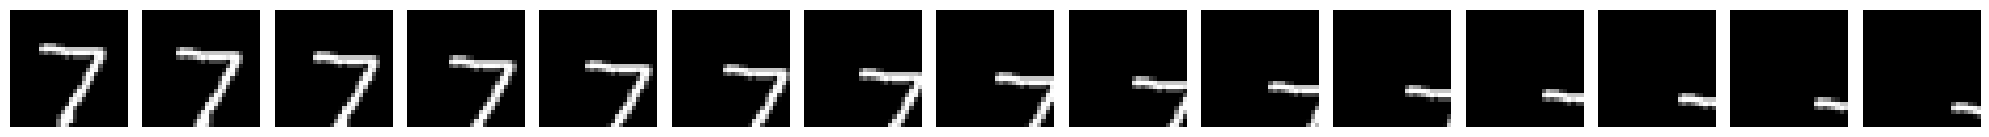

In [20]:
shifted = torch.stack([shift(sample,(i,i)) for i in range(1,16)])
plt.figure(figsize=(20, 4))
for i, img in enumerate(shifted):
    plt.subplot(1, len(shifted), i+1)
    plt.imshow(img.squeeze(0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
with torch.no_grad():
    probabilities = model(shifted.to(device)).detach().cpu().numpy()

category = np.argmax(probabilities[:,:,0,0],axis=1)
confidence = np.max(probabilities[:,:,0,0],axis=1)
print(category)
print(confidence)

[7 7 7 7 7 4 2 2 2 2 2 2 2 2 2]
[0.9237322  0.8472116  0.7064245  0.5310191  0.44211647 0.3154012
 0.40628985 0.6688523  0.6832862  0.6308118  0.55361754 0.5441214
 0.5088305  0.4516022  0.4410569 ]


In [22]:
sz = 224  # == 8 * 28
patch_sz = 28
image = torch.zeros(1,sz,sz,device=device)
for _ in range(12):
    i = np.random.randint(0, len(train_dataset))
    x, y = np.random.randint(0, sz-patch_sz), np.random.randint(0, sz-patch_sz)
    if (image[:,y:y+patch_sz, x:x+patch_sz]>0.5).any():
        continue
    image[:,y:y+patch_sz, x:x+patch_sz] += train_dataset[i][0].to(image.device)

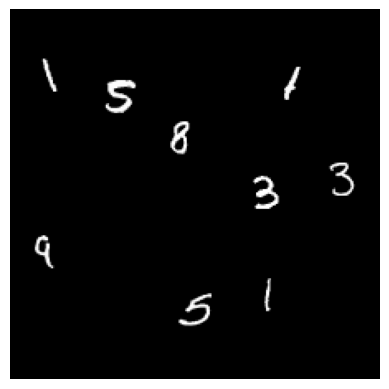

In [23]:
plt.imshow(image.squeeze(0).detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [24]:
with torch.no_grad():
    features = model[0](image.unsqueeze(0))
print(features.shape)

torch.Size([1, 8, 52, 52])


In [25]:
with torch.no_grad():
    out = model(image.unsqueeze(0))
print(out.shape)

torch.Size([1, 10, 50, 50])


In [26]:
confidencemap = out.max(dim=1).values
print(confidencemap.shape)

torch.Size([1, 50, 50])


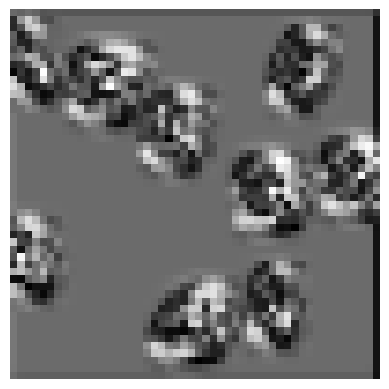

In [27]:
heatmap = confidencemap.squeeze(0).detach().cpu().numpy()
plt.imshow(heatmap, cmap='gray')
plt.axis('off')
plt.show()